# Fisheries competition and other CNN tricks

In this notebook we will classify species of fish. We will be using data from the [Kaggle competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/). 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter

In [70]:
import cv2
import matplotlib.pyplot as plt 
from datetime import datetime

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/competitit )<br/>
`kaggle competitions download -c the-nature-conservancy-fisheries-monitoring -p /data2/yinterian/fisheries` <br/>

In [3]:
PATH = Path("/data2/yinterian/fisheries")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/fisheries/test_stg1.zip'),
 PosixPath('/data2/yinterian/fisheries/annotations'),
 PosixPath('/data2/yinterian/fisheries/model-94.pth'),
 PosixPath('/data2/yinterian/fisheries/model.pth'),
 PosixPath('/data2/yinterian/fisheries/model-96.pth'),
 PosixPath('/data2/yinterian/fisheries/__MACOSX'),
 PosixPath('/data2/yinterian/fisheries/sample_submission_stg2.csv.zip'),
 PosixPath('/data2/yinterian/fisheries/model-93.pth'),
 PosixPath('/data2/yinterian/fisheries/mode_tmp.pth'),
 PosixPath('/data2/yinterian/fisheries/test_stg2.7z'),
 PosixPath('/data2/yinterian/fisheries/sample_submission_stg1.csv.zip'),
 PosixPath('/data2/yinterian/fisheries/train.zip'),
 PosixPath('/data2/yinterian/fisheries/train-300'),
 PosixPath('/data2/yinterian/fisheries/train'),
 PosixPath('/data2/yinterian/fisheries/bet_labels.json'),
 PosixPath('/data2/yinterian/fisheries/valid-300')]

In [4]:
list((PATH/"train").iterdir())

[PosixPath('/data2/yinterian/fisheries/train/DOL'),
 PosixPath('/data2/yinterian/fisheries/train/NoF'),
 PosixPath('/data2/yinterian/fisheries/train/LAG'),
 PosixPath('/data2/yinterian/fisheries/train/SHARK'),
 PosixPath('/data2/yinterian/fisheries/train/OTHER'),
 PosixPath('/data2/yinterian/fisheries/train/.DS_Store'),
 PosixPath('/data2/yinterian/fisheries/train/BET'),
 PosixPath('/data2/yinterian/fisheries/train/YFT'),
 PosixPath('/data2/yinterian/fisheries/train/ALB')]

In [5]:
list((PATH/"train"/"ALB").iterdir())[:5]

[PosixPath('/data2/yinterian/fisheries/train/ALB/img_02140.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_04320.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_06727.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_06086.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_04377.jpg')]

In [6]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

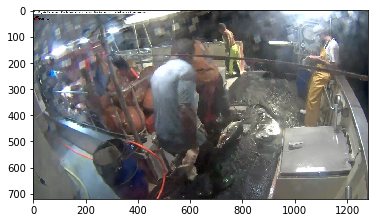

In [7]:
path = PATH/"train/ALB/img_02140.jpg"
im = read_image(path)
plt.imshow(im)

In [8]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(720, 1280, 3)

In [9]:
# let's look at the typical size of these images
files = list((PATH/"train/ALB/").iterdir()) + list((PATH/"train/SHARK/").iterdir())
dims = [read_image(str(p)).shape for p in files]
counts = Counter(dims)
counts

Counter({(720, 1280, 3): 1163,
         (854, 1518, 3): 6,
         (670, 1192, 3): 164,
         (750, 1280, 3): 330,
         (974, 1280, 3): 87,
         (718, 1276, 3): 109,
         (924, 1280, 3): 34,
         (700, 1244, 3): 2})

In [10]:
[(k[1]/k[0], counts[k]) for k in counts] 

[(1.7777777777777777, 1163),
 (1.7775175644028103, 6),
 (1.7791044776119402, 164),
 (1.7066666666666668, 330),
 (1.3141683778234086, 87),
 (1.777158774373259, 109),
 (1.3852813852813852, 34),
 (1.7771428571428571, 2)]

## Resizing images

In [11]:
paths = sorted([x for x in list((PATH/"train").iterdir()) if x.is_dir()])
paths

[PosixPath('/data2/yinterian/fisheries/train/ALB'),
 PosixPath('/data2/yinterian/fisheries/train/BET'),
 PosixPath('/data2/yinterian/fisheries/train/DOL'),
 PosixPath('/data2/yinterian/fisheries/train/LAG'),
 PosixPath('/data2/yinterian/fisheries/train/NoF'),
 PosixPath('/data2/yinterian/fisheries/train/OTHER'),
 PosixPath('/data2/yinterian/fisheries/train/SHARK'),
 PosixPath('/data2/yinterian/fisheries/train/YFT')]

In [12]:
## all files
files = [f for d in paths for f in list(d.iterdir())]
len(files)
files[-3:]

[PosixPath('/data2/yinterian/fisheries/train/YFT/img_00783.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/YFT/img_02756.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/YFT/img_05644.jpg')]

In [13]:
# here is how you get the class
files[0].parts[-2]

'ALB'

In [14]:
labels = [p.parts[-1] for p in paths]
labels

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [15]:
{v:k for k, v in enumerate(labels)}

{'ALB': 0,
 'BET': 1,
 'DOL': 2,
 'LAG': 3,
 'NoF': 4,
 'OTHER': 5,
 'SHARK': 6,
 'YFT': 7}

In [9]:
def resize_images(path, sz=300):
    im = read_image(path)
    sz2 = int(1.778*sz)
    return cv2.resize(im, (sz2, sz))

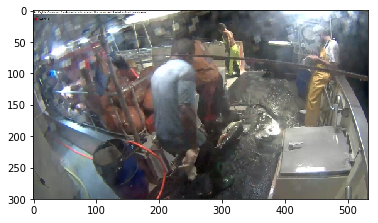

In [10]:
path = PATH/"train/ALB/img_02140.jpg"
im = resize_images(path)
plt.imshow(im)

In [18]:
train_path = PATH/"train-300"
valid_path = PATH/"valid-300"

train_path.mkdir(exist_ok=True)
valid_path.mkdir(exist_ok=True) 

In [19]:
def resize_all_images(train_path, valid_path, org_path, sz=300):
    np.random.seed(3)
    paths = [x for x in list(org_path.iterdir()) if x.is_dir()]
    for p in paths:
        label = p.parts[-1]
        (train_path/label).mkdir(exist_ok=True)
        (valid_path/label).mkdir(exist_ok=True) 
        files = list((org_path/label).iterdir())
        for f in files:
            f_name = f.parts[-1]
            if np.random.uniform() < 0.8:
                new_path = train_path/label/f_name
            else:
                new_path = valid_path/label/f_name
            im = resize_images(f)
            cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [20]:
#run just the first time
#resize_all_images(train_path, valid_path, PATH/"train")

In [21]:
# checking
for label in labels:
    all_files = len(list((PATH/"train"/label).iterdir()))
    train_files = len(list((train_path/label).iterdir()))
    valid_files = len(list((valid_path/label).iterdir()))
    print(label, all_files, train_files, valid_files)

ALB 1719 1377 342
BET 200 161 39
DOL 117 100 17
LAG 67 61 6
NoF 465 373 92
OTHER 299 233 66
SHARK 176 145 31
YFT 734 587 147


## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification tasks. For this problem we cannot crop much because we may leave the fish out.

In [11]:
# modified from fast.ai
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Resize, horizontal and vertical translations

(300, 533, 3)


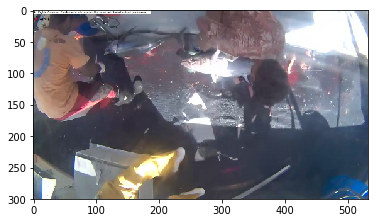

In [12]:
path = PATH/"train-300/ALB/img_03017.jpg"
im = read_image(path)
ratio = 1.778
sz1 = 280
sz2 = int(ratio*sz1)
im2 = random_crop(im, sz1, sz2)
plt.imshow(im)
print(im.shape)

(280, 497, 3)

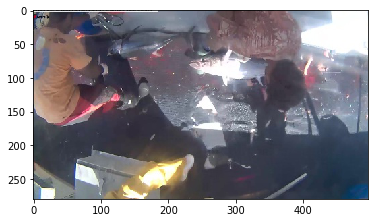

In [13]:
plt.imshow(im2)
im2.shape

### Random Rotation (-10, 10) 

-1.6103598324987445


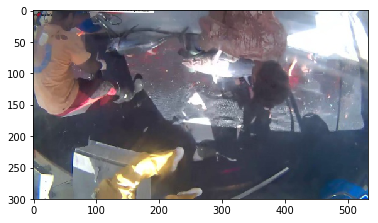

In [14]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot)

### Horizontal Flip

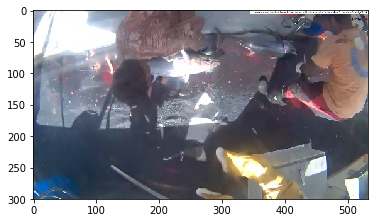

In [15]:
im_f = np.fliplr(im)
plt.imshow(im_f)

## Dataset

In [27]:
def resize_images_ratio(im, sz=300, r=1.778):
    sz2 = int(r*sz)
    return cv2.resize(im, (sz2, sz))

In [47]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [29]:
class FishDataset(Dataset):
    def __init__(self, PATH, train="train-300", transforms=False, sz=280):
        self.path_to_images = PATH/train
        self.transforms = transforms
        self.sz = sz
        self.sz2 = int(self.sz*1.778)
        self.paths = sorted([x for x in list(self.path_to_images.iterdir()) if x.is_dir()])
        self.files = [f for d in self.paths for f in list(d.iterdir())]
        self.labels = [p.parts[-1] for p in paths]
        self.label2ind = {v:k for k,v in enumerate(self.labels)}
        self.len = len(self.files)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        path = self.files[idx] 
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        # center crop
        if self.transforms:
            # assumes original images are 300x533 otherwise resize here.
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x, self.sz, self.sz2)
        else:
            x = resize_images_ratio(x, self.sz)
        # substract numbers from resnet34
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [30]:
train_ds = FishDataset(PATH, "train-300", transforms=True)
valid_ds = FishDataset(PATH, "valid-300")

In [31]:
len(train_ds), len(valid_ds)

(3037, 740)

In [32]:
batch_size = 10
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [33]:
# run this multiple times to get different images
x, y = train_ds[0]
#plt.imshow(np.rollaxis(x1, 2), cmap='gray')

In [34]:
x.shape,y

((3, 280, 497), 0)

In [35]:
x,y = next(iter(valid_dl))
x.shape

torch.Size([10, 3, 280, 497])

In [36]:
x, y = valid_ds[0]
x.shape

(3, 280, 497)

## Model

In [208]:
resnet = models.resnet34(pretrained=True)
#resnet 

In [210]:
class Net(nn.Module):
    def __init__(self, num_classes=8):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        #x = nn.Dropout(0.1)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.1)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [211]:
model = Net().cuda()

In [40]:
x, y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([10, 3, 280, 497]), torch.Size([10]))

In [41]:
x = x.cuda().float()
y = y.cuda()

In [42]:
x_features = model.top_model(x)
x_features.shape

torch.Size([10, 512, 9, 16])

In [43]:
# AdaptiveAvgPool2d would do a similar job if the input is [64, 512, 10, 20]
# that is why this model will fit any input size
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)
x_features_ave.shape

torch.Size([10, 512, 1, 1])

In [44]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([10, 512])

In [45]:
y_hat = model(x)
y_hat.shape

torch.Size([10, 8])

In [46]:
y.shape

torch.Size([10])

In [47]:
_, pred = torch.max(y_hat, 1)
pred

tensor([ 7,  3,  0,  2,  2,  4,  4,  0,  4,  2], device='cuda:0')

In [48]:
y

tensor([ 5,  7,  3,  7,  5,  7,  7,  7,  0,  6], device='cuda:0')

In [49]:
pred.eq(y).sum()

tensor(0, device='cuda:0')

In [50]:
# This loss combines a Sigmoid layer and the BCELoss in one single class. see
# https://pytorch.org/docs/master/nn.html#torch.nn.BCEWithLogitsLoss
F.cross_entropy(y_hat, y).item()

2.173676013946533

## Learning rate finder

In [79]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [80]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-6, lr_high=0.4, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [53]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [54]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl)

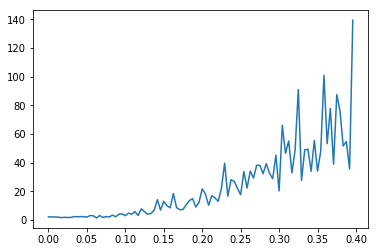

In [55]:
plt.plot(lrs, losses)
plt.show()

## Triangular learning rate training

In [77]:
def get_triangular_lr2(lr_low, lr_high, stepesize):
    iterations = 2*stepesize
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [57]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, lr_high=0.01):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss %.3f" % (sum_loss/total))
        val_metrics(model, valid_dl)
    return sum_loss/total

In [58]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))

## Training with triangular rates

In [59]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-5, lr_high=0.01):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [60]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [61]:
model = Net().cuda()

In [62]:
val_metrics(model, valid_dl)

val loss 2.090 and accuracy 0.107


In [63]:
training_loop(model, train_dl, valid_dl, steps=1)

train loss 1.283
val loss 1.075 and accuracy 0.685
train loss 0.692
val loss 0.592 and accuracy 0.804
train loss 0.358
val loss 0.332 and accuracy 0.891
train loss 0.225
val loss 0.314 and accuracy 0.896
----End of step Time elapsed 0:03:22.068373


In [64]:
training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-6, lr_high=0.005)

train loss 0.206
val loss 0.327 and accuracy 0.892
train loss 0.234
val loss 0.317 and accuracy 0.900
train loss 0.148
val loss 0.237 and accuracy 0.919
train loss 0.112
val loss 0.227 and accuracy 0.922
----End of step Time elapsed 0:03:21.852370


In [65]:
training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-6, lr_high=0.005)

train loss 0.110
val loss 0.241 and accuracy 0.932
train loss 0.182
val loss 0.226 and accuracy 0.938
train loss 0.118
val loss 0.205 and accuracy 0.945
train loss 0.084
val loss 0.204 and accuracy 0.946
----End of step Time elapsed 0:03:22.382840


## Unfreezing layers

In [84]:
# save model
def save_model(m, p): 
    torch.save(m.state_dict(), p)
p = PATH/"model-94.pth"
save_model(model, p)

In [79]:
# load model
#p = PATH/"model.pth"
model.load_state_dict(torch.load(p))

In [80]:
val_metrics(model, valid_dl)

val loss 0.204 and accuracy 0.946


In [81]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [82]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [83]:
unfreeze(model, 7)
unfreeze(model, 6)

In [85]:
train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-6, lr_high=1e-4)

train loss 0.099
val loss 0.391 and accuracy 0.896
train loss 0.130
val loss 0.363 and accuracy 0.897
train loss 0.060
val loss 0.150 and accuracy 0.957
train loss 0.029
val loss 0.144 and accuracy 0.958


0.028951580384896456

In [86]:
p = PATH/"model-96.pth"
save_model(model, p)

In [87]:
train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-7, lr_high=1e-4)

train loss 0.037
val loss 0.562 and accuracy 0.855
train loss 0.062
val loss 0.242 and accuracy 0.942
train loss 0.027
val loss 0.134 and accuracy 0.965
train loss 0.017
val loss 0.131 and accuracy 0.962


0.01666880666809129

In [212]:
# try unfreezing more layers
p = PATH/"model-96.pth"
model.load_state_dict(torch.load(p))

In [213]:
val_metrics(model, valid_dl)

val loss 0.144 and accuracy 0.958


In [214]:
unfreeze(model, 5)
unfreeze(model, 4)

## Bounding boxes and multi-task learning
A kaggle user has created bounding boxes for each fish in the training set. [Here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/discussion/25902) is a link to download them. We will use the bounding boxes by training a model to not only predict the class of the fish but also the bounding box.

### Getting bounding boxes map

In [16]:
import ujson as json
import requests

In [17]:
url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'
annot_urls = {
        '5458/bet_labels.json': 'bd20591439b650f44b36b72a98d3ce27',
        '5459/shark_labels.json': '94b1b3110ca58ff4788fb659eda7da90',
        '5460/dol_labels.json': '91a25d29a29b7e8b8d7a8770355993de',
        '5461/yft_labels.json': '9ef63caad8f076457d48a21986d81ddc',
        '5462/alb_labels.json': '731c74d347748b5272042f0661dad37c',
        '5463/lag_labels.json': '92d75d9218c3333ac31d74125f2b380a'
    }

In [18]:
# download annotations
def download_annotations():
    anno_dir = PATH/"annotations"
    anno_dir.mkdir(exist_ok=True)
    for url_suffix in annot_urls:
        url = url_prefix + url_suffix
        r = requests.get(url, allow_redirects=True)
        json_file = url_suffix.split("/")[1]
        open(anno_dir/json_file, 'wb').write(r.content)
#download_annotations()

In [19]:
jfiles = list((PATH/"annotations").iterdir())
jfiles

[PosixPath('/data2/yinterian/fisheries/annotations/shark_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/yft_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/alb_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/lag_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/bet_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/dol_labels.json')]

In [20]:
bb_json = {}
jfiles = list((PATH/"annotations").iterdir())
for f in jfiles:
    j = json.load(open(f, 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [21]:
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [22]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [23]:
def get_Y(path, label2ind):
    """Given an image path get y"""
    im_name = path.parts[-1]
    im_class = label2ind[path.parts[-2]]
    if im_name in bb_json:
        x = bb_json[im_name]
        return np.array([x['y'], x['x'], x['y'] + x['height'], x['x']+ x['width'], im_class])
    return np.array([0.0, 0.0, 0.0, 0.0, im_class])

In [24]:
def get_bb(files, label2ind):
    return [get_Y(p, label2ind) for p in files]

### Transfoms with bounding boxes

In [25]:
def make_bb_px(y, s):
    """ Makes an image of size x retangular bounding box"""
    r,c,*_ = s #s is shape of x
    Y = np.zeros((r, c))
    y = y.astype(np.int)
    Y[y[0]:y[2], y[1]:y[3]] = 1.
    return Y

def to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [26]:
def resize_images_ratio(im, sz=300, r=1.778):
    sz2 = int(r*sz)
    return cv2.resize(im, (sz2, sz))

In [27]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [28]:
def random_cropXY(x, Y, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    x = crop(x, start_r, start_c, target_r, target_c)
    Y = crop(Y, start_r, start_c, target_r, target_c)
    return x, Y

In [29]:
def get_shape_original_images():
    paths = [d for d in list((PATH/"train").iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    shapes = {f.parts[-1]: cv2.imread(str(f)).shape for f in files}
    return shapes

In [30]:
shapes = get_shape_original_images()

In [31]:
def transformsXY(path, bb, transforms, shape_x, sz):
    sz2 = int(sz*1.778)
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    # make Y with the original size of x
    Y = make_bb_px(bb, shape_x)
    if transforms:
        # already resized to 300
        #x = resize_images_ratio(x, sz+20)
        Y = resize_images_ratio(Y, 300)
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y, sz, sz2)
    else:
        x = resize_images_ratio(x, sz)
        Y = resize_images_ratio(Y, sz)
    return x, to_bb(Y)

In [32]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [33]:
# testing
train_path=PATH/"train-300"
paths = [d for d in list(train_path.iterdir()) if d.is_dir()]
files = [f for d in paths for f in list(d.iterdir())]
labels = [p.parts[-1] for p in paths]
label2ind = {v:k for k,v in enumerate(labels)}
test = files[:2]

In [34]:
test

[PosixPath('/data2/yinterian/fisheries/train-300/DOL/img_00983.jpg'),
 PosixPath('/data2/yinterian/fisheries/train-300/DOL/img_01185.jpg')]

In [35]:
bbs = get_bb(test, label2ind)

In [36]:
im = cv2.imread(str(test[1]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
bb = bbs[1][:4]
bb

array([420.18, 331.35, 499.14, 566.82])

In [37]:
Y = make_bb_px(bb, shapes["img_01185.jpg"])
Y = resize_images_ratio(Y, 300)
bb0 = to_bb(Y)
bb0

array([175., 138., 207., 235.], dtype=float32)

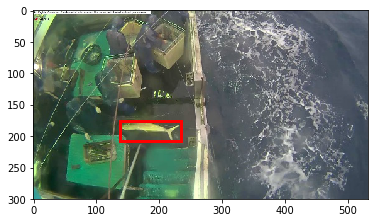

In [38]:
show_corner_bb(im, bb0)

In [39]:
im, bb_t = transformsXY(str(test[1]), bb, True, shapes["img_01185.jpg"], sz=280)

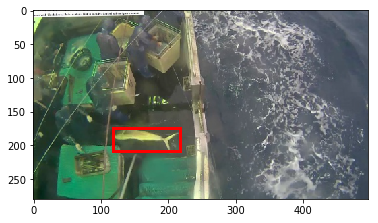

In [40]:
show_corner_bb(im, bb_t)

## New dataset
Here I have to start with the larger dataset because I need to transform x and y at the same time.

In [41]:
#shapes

In [42]:
def get_files(path=PATH/"train-300"):
    paths = [d for d in list(path.iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    labels = [p.parts[-1] for p in paths]
    return files, labels

In [43]:
train_files, labels = get_files()
valid_files, labels = get_files(PATH/"valid-300")

In [44]:
class FishDataset2(Dataset):
    def __init__(self, files, labels, shapes, transforms=False, sz=280):
        self.transforms = transforms
        self.sz = sz
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.y = get_bb(self.files, self.label2ind)
        self.shapes = shapes
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        shape = self.shapes[path.parts[-1]]
        y = self.y[idx]
        bb = y[:4]
        x, y_bb = transformsXY(path, bb, self.transforms, shape, self.sz)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y[4], y_bb

In [45]:
train_ds2 = FishDataset2(train_files, labels, shapes, transforms=True)
valid_ds2 = FishDataset2(valid_files, labels, shapes)

In [48]:
x, y_class, y_bb= train_ds2[20]
x.shape, y_class, y_bb

((3, 280, 497), 0.0, array([151., 248., 200., 342.], dtype=float32))

In [49]:
batch_size = 64
train_dl2 = DataLoader(train_ds2, batch_size=batch_size, shuffle=True)
valid_dl2 = DataLoader(valid_ds2, batch_size=batch_size)

## Model

In [50]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 8)
        self.fc3 = nn.Linear(512, 4)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        #x = nn.Dropout(0.1)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.1)(x)
        x = self.bn2(x)
        x_class = self.fc2(x)
        x_bb = self.fc3(x)
        return x_class, x_bb

In [51]:
net = Net2().cuda()

In [52]:
x, y1, y2 = next(iter(train_dl2))

In [53]:
y1 = y1.cuda()
y2 = y2.cuda()
out_class, out_bb = net(x.float().cuda())

In [54]:
y1.long()

tensor([ 1,  1,  7,  7,  6,  6,  7,  6,  1,  7,  4,  7,  2,  5,
         3,  4,  6,  7,  7,  1,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  6,  2,  7,  7,  6,  7,  7,  7,  7,  7,  7,
         6,  3,  7,  1,  7,  7,  7,  1,  5,  1,  7,  7,  7,  7,
         6,  1,  4,  7,  4,  6,  4,  7], device='cuda:0')

In [55]:
F.cross_entropy(out_class, y1.long())

tensor(2.1865, device='cuda:0')

In [57]:
F.l1_loss(out_bb, y2.float()).item()

156.03250122070312

In [72]:
def train_triangular_policy2(model, train_dl, valid_dl, lr_low=1e-5,
                             lr_high=0.01):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y_class, y_bb) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda().long()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss = F.cross_entropy(out_class, y_class)
            loss += F.l1_loss(out_bb, y_bb)/1000.0
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss %.3f" % (sum_loss/total))
        val_metrics2(model, valid_dl)
    return sum_loss/total

In [73]:
def val_metrics2(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y_class, y_bb) in enumerate(valid_dl):
        batch = y_class.shape[0]
        
        x = x.cuda().float()
        y_class = y_class.cuda().long()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss = F.cross_entropy(out_class, y_class)
        loss += F.l1_loss(out_bb, y_bb)/1000.0
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))

In [74]:
def training_loop2(model, train_dl, valid_dl, steps=3, lr_low=1e-5, lr_high=0.01):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy2(model, train_dl, valid_dl, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [75]:
net = Net2().cuda()

In [68]:
val_metrics2(net, valid_dl2)

val loss 2.184 and accuracy 0.286


In [81]:
training_loop2(net, train_dl2, valid_dl2, steps=1, lr_low=1e-4, lr_high=0.02)

train loss 1.408
val loss 1.714 and accuracy 0.588
train loss 0.955
val loss 0.660 and accuracy 0.827
train loss 0.489
val loss 0.460 and accuracy 0.886
train loss 0.354
val loss 0.420 and accuracy 0.892
----End of step Time elapsed 0:04:34.343616


In [82]:
training_loop2(net, train_dl2, valid_dl2, steps=1, lr_low=1e-5, lr_high=0.01)

train loss 0.353
val loss 0.555 and accuracy 0.857
train loss 0.414
val loss 0.462 and accuracy 0.886
train loss 0.302
val loss 0.358 and accuracy 0.915
train loss 0.255
val loss 0.348 and accuracy 0.927
----End of step Time elapsed 0:04:31.220433


In [83]:
training_loop2(net, train_dl2, valid_dl2, steps=1, lr_low=1e-5, lr_high=0.01)

train loss 0.283
val loss 0.406 and accuracy 0.903
train loss 0.314
val loss 0.393 and accuracy 0.916
train loss 0.242
val loss 0.348 and accuracy 0.914
train loss 0.190
val loss 0.336 and accuracy 0.922
----End of step Time elapsed 0:04:31.811037


In [ ]:
training_loop2(net, train_dl2, valid_dl2, steps=1, lr_low=1e-6, lr_high=0.005)

train loss 0.204
val loss 0.338 and accuracy 0.923


## Fully convolutional model

# References
This notebook is based on the Keras implementation from [fast.ai](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson7.ipynb).